In [118]:
from torch import nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
from sklearn.mixture import GaussianMixture

def initialize_weights_egnn(model):
    """
    Initializes the weights of the given EGNN model using Xavier initialization.
    
    Args:
    - model (nn.Module): The neural network model to initialize.
    """
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.xavier_normal_(param)  # Xavier initialization (normal distribution)
        elif 'bias' in name:
            init.zeros_(param)  # Bias initialized to zero

# Example usage for your EGNN model
class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, n_layers):
        super(EGNN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(in_node_nf, hidden_nf)] + 
                                    [nn.Linear(hidden_nf, hidden_nf) for _ in range(n_layers-1)] +
                                    [nn.Linear(hidden_nf, out_node_nf)])
        self.n_layers = n_layers

    def forward(self, node_features, node_coords, edge_indices, edge_features):
        x = node_features
        for layer in self.layers:
            x = torch.relu(layer(x))
        return x, node_coords  # For simplicity, return node coordinates unchanged here
    
# Initialize the EGNN model
egnn = EGNN(in_node_nf=5, hidden_nf=10, out_node_nf=2, n_layers=3)

# Apply Xavier initialization to the model weights
initialize_weights_egnn(egnn)

# Check the initialized weights
print(egnn)

class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    re
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=True, attention=False, normalize=True, coords_agg='mean', tanh=True):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        droprate=0.3
        edge_coords_nf = 1
        

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Dropout(p=droprate),
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)
        
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Dropout(p=droprate),
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord = coord + agg
        return coord

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr


class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, in_edge_nf=0, device='cpu', act_fn=nn.SiLU(), n_layers=3, residual=False, attention=False, normalize=True, tanh=False):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding_in = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf,
                                                act_fn=act_fn, residual=residual, attention=attention,
                                                normalize=normalize, tanh=tanh))
        self.to(self.device)

    def forward(self, h, x, edges, edge_attr=None):
        h = self.embedding_in(h)
        hist_coord=[]
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x)
            hist_coord.append(x.detach().numpy())
        h = self.embedding_out(h)
        # # Visualize coordinates before and after training
        # plt.figure(figsize=(6, 6))
        # plt.scatter(hist_coord[0][:, 0], hist_coord[0][:, 1], color='blue', label='first')
        # plt.scatter(hist_coord[1][:, 0], hist_coord[1][:, 1], color='red', label='second')
        # plt.scatter(hist_coord[-1][:, 0], hist_coord[-1][:, 1], color='brown', label='third')
        # plt.legend()
        # plt.title("Original vs Predicted Coordinates")
        # plt.show()

        return h, x

    def forward_with_uncertainty(self, node_features, node_coords, edge_indices, n_samples=10):
        h_predictions = []
        x_predictions = []
        
        # Sample forward passes
        for _ in range(n_samples):
            h, x = self.forward(node_features, node_coords, edge_indices)
            
            # Store predictions separately
            h_predictions.append(h)
            x_predictions.append(x)
        
        # Stack the results for both h and x
        h_predictions = torch.stack(h_predictions)
        x_predictions = torch.stack(x_predictions)
        # Compute mean and uncertainty (variance) for both h and x
        h_mean = h_predictions.mean(dim=0)
        x_mean = x_predictions.mean(dim=0)

        # Compute uncertainty as standard deviation across the n_samples dimension
        h_uncertainty = h_predictions.std(dim=0).mean()  # Standard deviation for h (per node)
        x_uncertainty = x_predictions.mean(dim=0).mean()  # Standard deviation for x (per node)
        return (h_mean, h_uncertainty), (x_mean, x_uncertainty)


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def get_edges(points, cutoff):
    """
    Creates edge index and edge distances for a point cloud within a cutoff radius.

    Args:
        points: A PyTorch tensor of shape [num_points, 3] representing the point cloud.
        cutoff: The cutoff radius.

    Returns:
        edge_index: A PyTorch tensor of shape [2, num_edges] representing the edge index.
        edge_attr: A PyTorch tensor of shape [num_edges, 1] representing the edge distances.
    """

    dist_mat = torch.cdist(points, points)
    mask = dist_mat > cutoff
    dist_mat[mask] = 0

    edge_index = torch.nonzero(dist_mat, as_tuple=True)
    edge_attr = dist_mat[edge_index[0], edge_index[1]].unsqueeze(1)

    return edge_index, edge_attr    


EGNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1-2): 2 x Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [171]:
def generate_data(num_nodes, feature_dim, cutoff=0.1):
    node_features = torch.rand((num_nodes, feature_dim))  # Random node features
    node_coords = torch.rand((num_nodes, 2))  # Random 2D coordinates
    edge_index, _ = get_edges(node_coords, cutoff)  # Generate edges
    return node_features, node_coords, edge_index

def update_coordinates(node_coords, masses, alpha=1.0):
    # Ensure masses is of shape [20, 1] for broadcasting
    masses = masses.squeeze()  # Shape: [20]
    
    # Compute centroid using mass-weighted average of coordinates
    mass_sum = masses.sum()
    centroid = (node_coords.T * masses).T.sum(dim=0) / mass_sum  # Shape: [2]
    
    # Move nodes towards centroid proportionally to their masses
    displacement = alpha * masses[:, None] * (centroid - node_coords)  # Shape: [20, 2]
    
    # Update coordinates
    updated_coords = node_coords + displacement
    
    return updated_coords

# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'

# Initialize model
model = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)

model.train()  # Keep dropout active

node_features, node_coords, edge_index = generate_data(num_nodes, feature_dim, cutoff)
target_coords = update_coordinates(node_coords,node_features)
target_features = torch.norm(node_features)
model.forward_with_uncertainty(node_features, node_coords, edge_index)


((tensor([[0.0756],
          [0.0956],
          [0.0834],
          [0.0864],
          [0.0910],
          [0.0978]], grad_fn=<MeanBackward1>),
  tensor(0.0142, grad_fn=<MeanBackward0>)),
 (tensor([[0.5315, 0.3847],
          [0.3802, 0.8287],
          [0.6659, 0.8189],
          [0.8487, 0.4645],
          [0.2715, 0.7367],
          [0.0791, 0.5711]], grad_fn=<MeanBackward1>),
  tensor(0.5485, grad_fn=<MeanBackward0>)))

In [235]:
def prune_weights(model, threshold=1e-6):
    for param in model.parameters():
        param.data = torch.where(torch.abs(param) < threshold, torch.tensor(0.0, device=param.device), param.data)
def freeze_parameters(model, threshold=1e-6):
    for name, param in model.named_parameters():
        # Freeze pruned parameters (those that were set to zero)
        if torch.all(torch.abs(param.data) < threshold):
            param.requires_grad = False
        else:
            param.requires_grad = True


In [276]:
# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'
n_samples=10
# Example: Prune weights, freeze pruned parameters, and train on uncertain data
# Example model instantiation and optimizer setup
model = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
k=0
j=0
model.train()  # Set model to training mode
loss_fn = nn.MSELoss()

while j<100:
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    # Uncertainty sampling for training
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    # Get mean predictions and uncertainties
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = model.forward_with_uncertainty(node_features, node_coords, edge_indices, n_samples)
    # Use uncertainty to filter out high-uncertainty predictions for training
    mask = (h_uncertainty > 0.0002) & (x_uncertainty > 0.6)
    # mask = (x_uncertainty > 0.5)
    # print("uncer hx",h_uncertainty.item(),x_uncertainty.item())
    if (mask and j<100):
        # Perform pruning
        prune_weights(model)
        # Freeze pruned parameters
        freeze_parameters(model)
        # Apply the mask to h_mean and x_mean (you need to ensure that the mask applies element-wise)
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.0*loss_h
        loss.backward()
        optimizer.step()
        print("Got example",loss.item(),"looshx", loss_h.item(),loss_coord.item(),"uncertx",x_uncertainty,j,k)
        j+=1
    if ((k<100) and (mask==False)):
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.00*loss_h
        loss.backward()
        optimizer.step()
        print("loss",loss.item(),k)
        k+=1


loss 0.040743451565504074 0
loss 0.039230890572071075 1
loss 0.023673811927437782 2
loss 0.008406340144574642 3
loss 0.01565004326403141 4
loss 0.031296033412218094 5
loss 0.01319704670459032 6
loss 0.03598467633128166 7
loss 0.05487140640616417 8
loss 0.017328402027487755 9
Got example 0.009528505615890026 looshx 0.7067049741744995 0.009528505615890026 uncertx tensor(0.6339, grad_fn=<MeanBackward0>) 0 10
loss 0.009891226887702942 10
loss 0.018198398873209953 11
loss 0.007037747651338577 12
loss 0.018561387434601784 13
loss 0.00227059586904943 14
loss 0.004901542793959379 15
loss 0.0553366094827652 16
Got example 0.02627299726009369 looshx 1.8155312538146973 0.02627299726009369 uncertx tensor(0.6768, grad_fn=<MeanBackward0>) 1 17
Got example 0.015741201117634773 looshx 1.1919529438018799 0.015741201117634773 uncertx tensor(0.6228, grad_fn=<MeanBackward0>) 2 17
loss 0.0121029457077384 17
loss 0.006613392848521471 18
loss 0.002636938588693738 19
loss 0.009103568270802498 20
loss 0.003732

In [277]:
# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'
n_samples=10
# Example: Prune weights, freeze pruned parameters, and train on uncertain data
# Example model instantiation and optimizer setup
egnn2 = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)
optimizer = torch.optim.Adam(egnn2.parameters(), lr=1e-3)
k=0
j=0
egnn2.train()  # Set model to training mode
loss_fn = nn.MSELoss()

while j<200:
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    # Perform pruning
    # prune_weights(egnn2)
    # # Freeze pruned parameters
    # freeze_parameters(egnn2)
    # Uncertainty sampling for training
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    # Get mean predictions and uncertainties
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = egnn2.forward_with_uncertainty(node_features, node_coords, edge_indices, n_samples)
    # Use uncertainty to filter out high-uncertainty predictions for training
    mask = (h_uncertainty < 0.03) & (x_uncertainty < 0.4)
    mask = (x_uncertainty < 0.6)
    mask = True
    # print("uncer hx",h_uncertainty.item(),x_uncertainty.item())
    if mask:
        # Apply the mask to h_mean and x_mean (you need to ensure that the mask applies element-wise)
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.0*loss_h
        loss.backward()
        optimizer.step()
        print("Got example",loss.item(),"looshx", loss_h.item(),loss_coord.item(),"uncertx",x_uncertainty,j)
        j+=1
        k+=1
    # if k<100:
    #     optimizer.zero_grad()
    #     loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
    #     loss_h= loss_fn(target_h,torch.norm(h_mean))
    #     loss= loss_coord+0.00*loss_h
    #     loss.backward()
    #     optimizer.step()
    #     print("loss",loss.item(),k)
    #     k+=1


Got example 0.02689114212989807 looshx 2.1002349853515625 0.02689114212989807 uncertx tensor(0.6466, grad_fn=<MeanBackward0>) 0
Got example 0.010605634190142155 looshx 1.075644850730896 0.010605634190142155 uncertx tensor(0.4916, grad_fn=<MeanBackward0>) 1
Got example 0.03353780880570412 looshx 1.149060845375061 0.03353780880570412 uncertx tensor(0.4518, grad_fn=<MeanBackward0>) 2
Got example 0.015196838416159153 looshx 1.0691163539886475 0.015196838416159153 uncertx tensor(0.6277, grad_fn=<MeanBackward0>) 3
Got example 0.012956549413502216 looshx 0.543189525604248 0.012956549413502216 uncertx tensor(0.5259, grad_fn=<MeanBackward0>) 4
Got example 0.015906650573015213 looshx 0.34249547123908997 0.015906650573015213 uncertx tensor(0.4371, grad_fn=<MeanBackward0>) 5
Got example 0.024317631497979164 looshx 1.0896135568618774 0.024317631497979164 uncertx tensor(0.5724, grad_fn=<MeanBackward0>) 6
Got example 0.041755396872758865 looshx 1.1144107580184937 0.041755396872758865 uncertx tensor(0

0.001696467399597168
-2.9443297535181046e-05


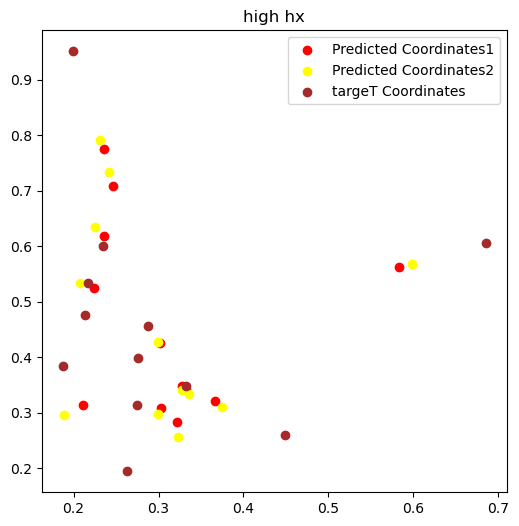

0.0021386146545410156
-1.9683269783854485e-05


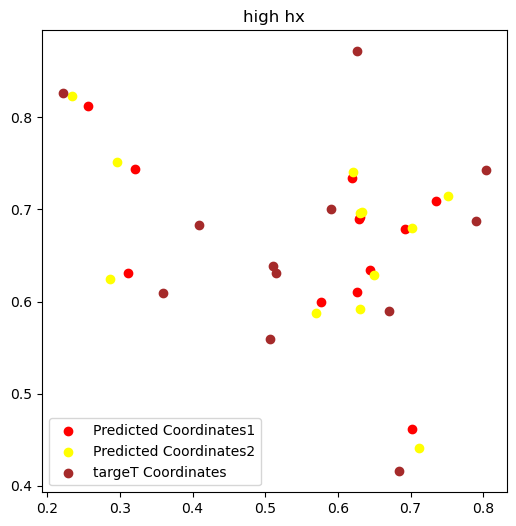

-0.0011733174324035645
-0.0009558254387229681


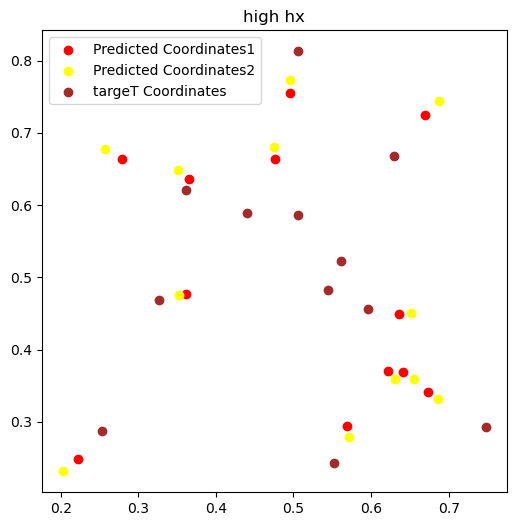

0.0002530217170715332
3.334064967930317e-05


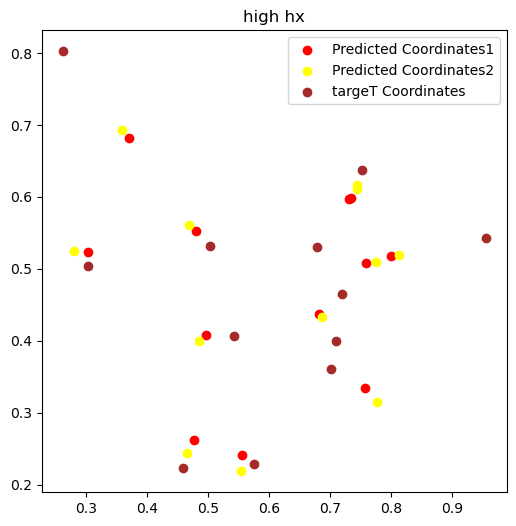

-0.0008424818515777588
-0.0011721011251211166


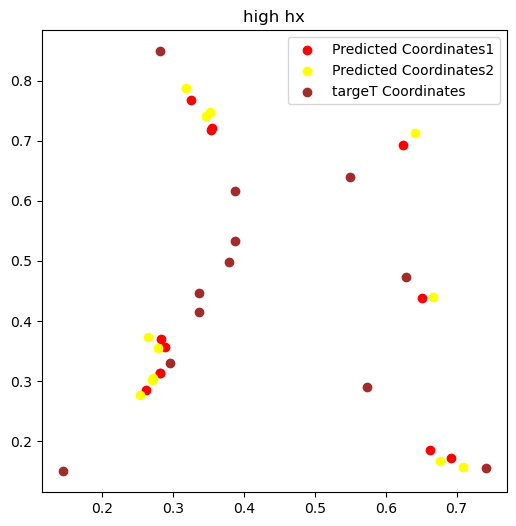

0.0013269782066345215
-0.0007808627560734749


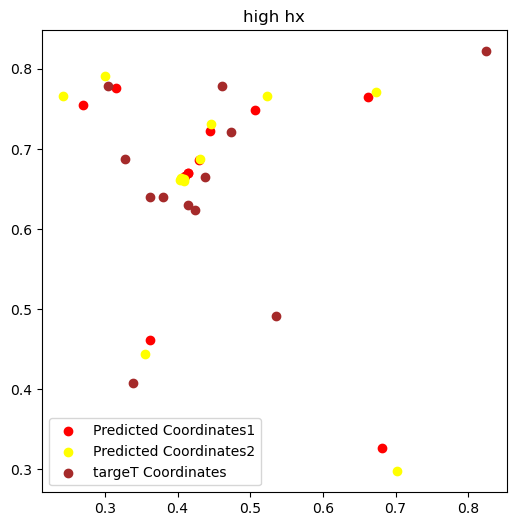

0.003266453742980957
-0.001897522248327732


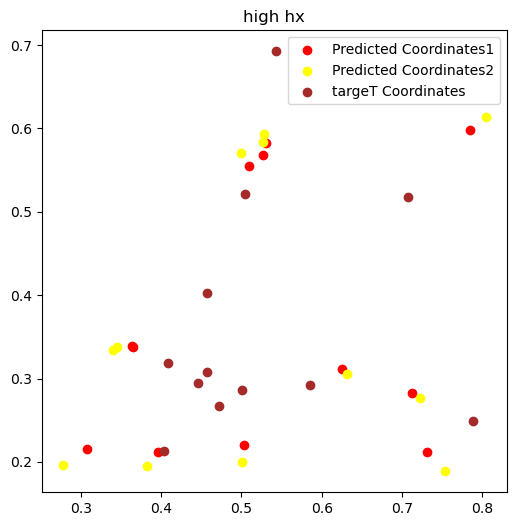

0.0009348392486572266
-0.000512563856318593


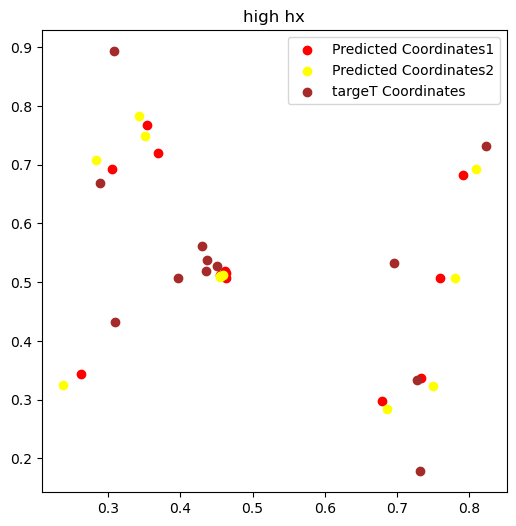

0.00264015793800354
-4.613865166902542e-05


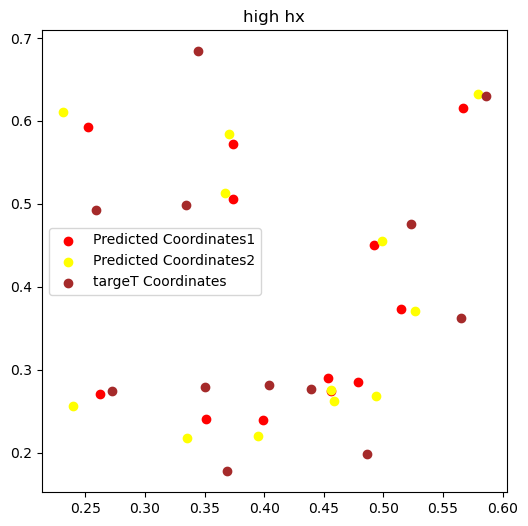

-0.00014638900756835938
0.0010776636190712452


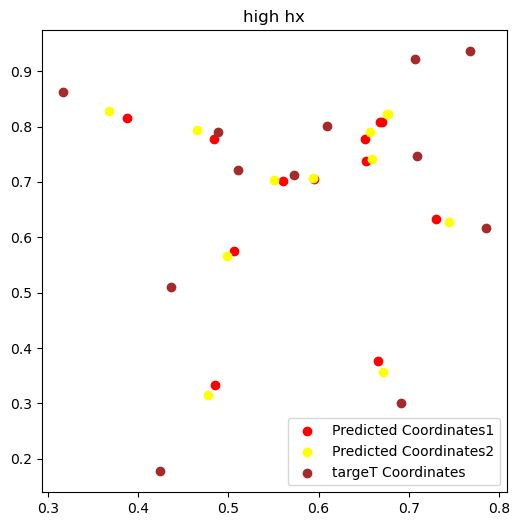

In [284]:
egnn2.eval()
model.eval()
n_samples=10
num_nodes = 12
loss_fn = nn.MSELoss()
for _ in range(10):
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = model.forward_with_uncertainty(node_features, node_coords,edge_indices)
    loss_coordm = loss_fn(target_coords,x_mean)
    (h_mean, h_uncertainty), (x_mean2, x_uncertainty2) = egnn2.forward_with_uncertainty(node_features, node_coords, edge_indices)
    loss_coordegnn2 = loss_fn(target_coords,x_mean2)
    print((x_uncertainty-x_uncertainty2).item())
    print(loss_coordm.item()-loss_coordegnn2.item())
    plt.figure(figsize=(6, 6))
    # plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
    plt.scatter(x_mean.detach().numpy()[:, 0], x_mean.detach().numpy()[:, 1], color='red', label='Predicted Coordinates1')
    plt.scatter(x_mean2.detach().numpy()[:, 0], x_mean2.detach().numpy()[:, 1], color='yellow', label='Predicted Coordinates2')
    plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown', label='targeT Coordinates')
    # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
    plt.legend()
    plt.title("high hx")
    plt.show()




0.002719435840845108 0.29788926243782043


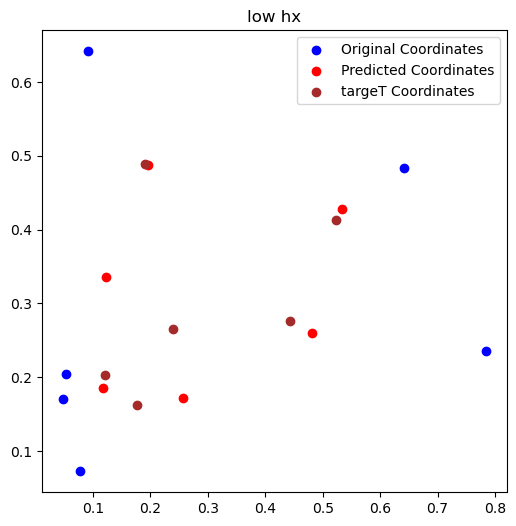

0.006383612751960754 0.2913109064102173


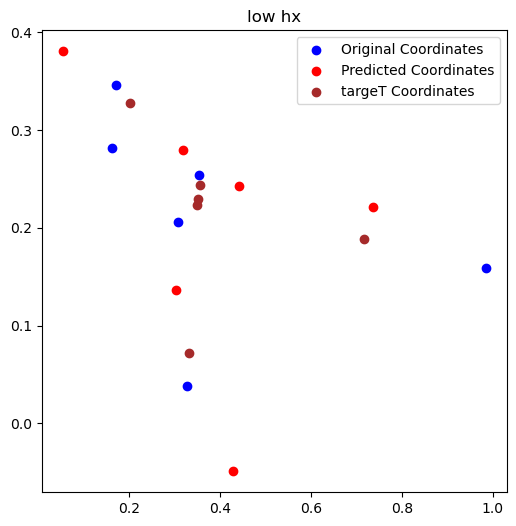

0.0017408615676686168 0.2865258455276489


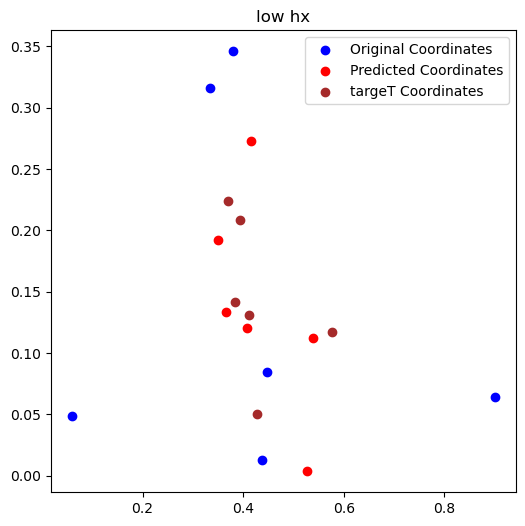

0.003760742722079158 0.7535416483879089


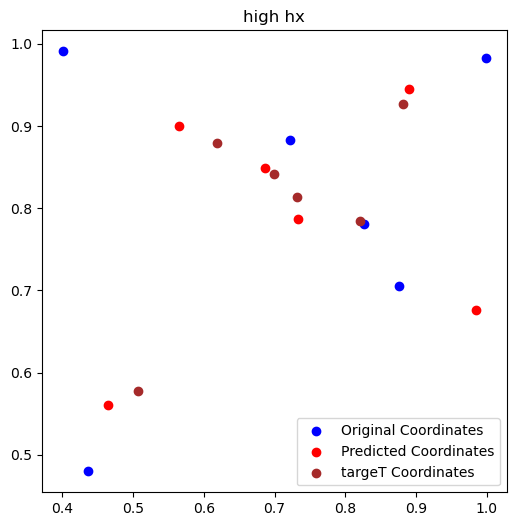

KeyboardInterrupt: 

In [248]:
egnn.eval()
n_samples=10
num_nodes = 6
loss_fn = nn.MSELoss()
for _ in range(1000):
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    # Get mean predictions and uncertainties
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = egnn.forward_with_uncertainty(node_features, node_coords, edge_indices, n_samples)
    loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data

    # Use uncertainty to filter out high-uncertainty predictions for training
    mask = (x_uncertainty > 0.7)
    if mask:
        print(loss_coord.item(),x_uncertainty.item())
        # Visualize coordinates before and after training
        plt.figure(figsize=(6, 6))
        plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
        plt.scatter(x_mean.detach().numpy()[:, 0], x_mean.detach().numpy()[:, 1], color='red', label='Predicted Coordinates')
        plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown', label='targeT Coordinates')
        # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
        plt.legend()
        plt.title("high hx")
        plt.show()
    mask = (x_uncertainty <0.3)
    if mask:
        print(loss_coord.item(),x_uncertainty.item())
        # Visualize coordinates before and after training
        plt.figure(figsize=(6, 6))
        plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
        plt.scatter(x_mean.detach().numpy()[:, 0], x_mean.detach().numpy()[:, 1], color='red', label='Predicted Coordinates')
        plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown', label='targeT Coordinates')
        # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
        plt.legend()
        plt.title("low hx")
        plt.show()
